In [1]:
## IMPORTS ##
import pickle
import pandas as pd
from Processing import prompt_dataset_with_langchain, sample_optimized # Pre-LLM processing 
from LLM import run_llms # LLM 
from Processing import process_gen_codes, semantic_pairs_manual # Post-LLM processing
from Analysis import convert_to_nested_json, displayJSONpretty # Intermediate Result Display
from Analysis import quickanalyze, load_embeddings, create_icdcodexvectors, get_score, meteor_15, manual_analysis #  Result Processing
from Analysis import code_histogram, frequencychart, create_metric_table, sts_score_dist_fig, code_features_dist  # Tables / Figures
from Testing import llm_generate, getCUI_desc

codesystem_list = ['ICD9CM', 'ICD10CM', 'CPT']
model_list = ["gpt-3.5-turbo-0301",
              "gpt-3.5-turbo-0613",
              "gpt-3.5-turbo-1106",
              "gpt-4-0314",
              "gpt-4-0613",
              "gpt-4-1106-preview",
              "gemini-pro",
              "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
              ]
base_suffix = ""
suffix_man = "_man"

In [7]:
## CREATE PROMPTS AND MATCH DESCRIPTIONS ##
codesystem_list = ['ICD9CM', 'ICD10CM', 'CPT']

for codesystem in codesystem_list:
    filepath = f"Raw/MSSM_ICD_Codes/{codesystem}.xlsx"
    df = await prompt_dataset_with_langchain(filepath)
    df.to_parquet(f"Output/Intermediate/{codesystem}prompts.parquet")

Processing API Calls: 100%|██████████| 7699/7699 [00:00<00:00, 14565.85it/s]


	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/ICD9CM/IMO0001/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): IMO0001 nan
	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/ICD9CM/IMO0002/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): IMO0002 nan
Cache saved


Processing API Calls: 100%|██████████| 15952/15952 [00:00<00:00, 70924.19it/s]


	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/ICD10CM/IMO0002/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): IMO0002 nan
	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/ICD10CM/IMO0001/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): IMO0001 nan
Cache saved


Processing API Calls: 100%|██████████| 4189/4189 [00:30<00:00, 138.36it/s]


	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/CPT/504649/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): 504649 nan
	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/CPT/99994/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): 99994 nan
	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/CPT/*Not%20Applicable/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): *Not Applicable nan
	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/CPT/71010/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): 71010 nan
	No result, error 404, message='Not Found', url=URL('https://uts-ws.nlm.nih.gov/rest/content/current/source/CPT/500158/atoms/preferred?apiKey=c727e7a7-51ef-421e-bf24-f038d7d1055d'): 500158 nan
	No result, error 4

In [ ]:
## CREATE MANUAL SUBSETS ##
# random samples
num_samples = 200
random_state = 42

for codesystem in codesystem_list:
    df_sample = pd.read_parquet(f'Output/Intermediate/{codesystem}prompts.parquet')
    df_sample =  sample_optimized(df_sample, num_samples, random_state)
    df_sample.to_parquet(f'Output/Intermediate/{codesystem}prompts_man.parquet')
    
# random samples
num_samples = 20
random_state = 25

for codesystem in codesystem_list:
    df_sample = pd.read_parquet(f'Output/Intermediate/{codesystem}prompts.parquet')
    df_sample_orig = pd.read_parquet(f'Output/Intermediate/{codesystem}prompts_man.parquet')
    df_sample =  sample_optimized(df_sample, num_samples, random_state, df_sample_orig)
    df_sample.to_parquet(f'Output/Intermediate/{codesystem}prompts_man_test.parquet')

In [ ]:
## TEST LLM GENERATION ##
df=pd.read_parquet(f"Output/Intermediate/ICD9CMprompts_man.parquet").head(5)

responses = llm_generate(df_prompt = df, 
             model_name='gpt-4-1106-preview', 
             max_tokens=50, 
             temperature=0.2,
             print_output=False)

for resp in responses:
    desc, code = getCUI_desc(resp,"ICD9CM")
    print("Generated code:",code, "\t\tMatched Description:", desc)

LLM running: [#########################] 5/5
Generated code: V49.89 		Matched Description: Other specified conditions influencing health status
Generated code: 355.0 		Matched Description: Lesion of sciatic nerve
Generated code: 333.1 		Matched Description: Essential and other specified forms of tremor
Generated code: 244.8 		Matched Description: Other specified acquired hypothyroidism
Generated code: 244.9 		Matched Description: Unspecified acquired hypothyroidism


In [ ]:
## GENERATE CODES ##
# df_ICD9mantest_filepath = 'Output/Intermediate/ICD9CMprompts_man_test.parquet'
# df_ICD10mantest_filepath = 'Output/Intermediate/ICD10CMprompts_man_test.parquet'
# df_CPTmantest_filepath = 'Output/Intermediate/CPTprompts_man_test.parquet'

# code_datasets_man_test = {"ICD9CM": pd.read_parquet(df_ICD9mantest_filepath), 
#                 "ICD10CM": pd.read_parquet(df_ICD10mantest_filepath),
#                 "CPT" : pd.read_parquet(df_CPTmantest_filepath)
#                           }

# df_ICD9man_filepath = 'Output/Intermediate/ICD9CMprompts_man.parquet'
# df_ICD10man_filepath = 'Output/Intermediate/ICD10CMprompts_man.parquet'
# df_CPTman_filepath = 'Output/Intermediate/CPTprompts_man.parquet'

# code_datasets_man = {"ICD9CM": pd.read_parquet(df_ICD9man_filepath), 
#                 "ICD10CM": pd.read_parquet(df_ICD10man_filepath),
#                 "CPT" : pd.read_parquet(df_CPTman_filepath)
#                           }

df_ICD9_filepath = 'Output/Intermediate/ICD9CMprompts.parquet'
df_ICD10_filepath = 'Output/Intermediate/ICD10CMprompts.parquet'
df_CPT_filepath = 'Output/Intermediate/CPTprompts.parquet'

run_code_datasets = {#"ICD9CM": pd.read_parquet(df_ICD9_filepath), 
                #"ICD10CM": pd.read_parquet(df_ICD10_filepath),
                "CPT" : pd.read_parquet(df_CPT_filepath)
                          }

run_model_list = [#"gpt-3.5-turbo-0301",
              #"gpt-3.5-turbo-0613",
              #"gpt-3.5-turbo-1106",
              #"gpt-4-0314",
              #"gpt-4-0613",
              #"gpt-4-1106-preview",
              #"gemini-pro",
              "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
              ]


await run_llms(run_model_list, run_code_datasets, "")


 CPT meta/llama-2-70b-chat


Processing batches:   0%|          | 0/6 [00:00<?, ?it/s]

Timed out description: 3100  Gastric restrictive procedure, open; revision of subcutaneous port component only
Timed out description: 3101  Gastrostomy, open; without construction of gastric tube (eg, Stamm procedure) (separate procedure)
Timed out description: 3102  Replacement of gastrostomy tube, percutaneous, includes removal, when performed, without imaging or endoscopic guidance; requiring revision of gastrostomy tract
Timed out description: 3103  Laparoscopy, surgical; gastrostomy, without construction of gastric tube (eg, Stamm procedure) (separate procedure)
Timed out description: 3104  Gastrectomy, partial, distal; with gastrojejunostomy
Timed out description: 3105  Esophagogastroduodenoscopy, flexible, transoral; with optical endomicroscopy
Timed out description: 3106  Excision, local; malignant tumor of stomach
Timed out description: 3107  Esophagogastric fundoplasty, with fundic patch (Thal-Nissen procedure)
Timed out description: 3108  Esophagectomy, total or near total, 

Processing batches: 100%|██████████| 6/6 [05:06<00:00, 51.04s/it] 


Clean cache saved
Clean cache saved


In [3]:
## REVIEW OUTPUT ##
with open(f"Output/Intermediate/results{base_suffix}_clean.pkl", "rb") as file:
    results_dict = pickle.load(file)
    
results_json = convert_to_nested_json(results_dict)
displayJSONpretty(results_json)

with open(f"Output/Intermediate/results{suffix_man}_clean.pkl", "rb") as file:
    results_dict = pickle.load(file)
    
results_json = convert_to_nested_json(results_dict)
displayJSONpretty(results_json)
    

In [6]:
## PROCESS GENERATED CODES ##
code_datasets={}

with open(f"Output/Intermediate/results{base_suffix}_clean.pkl", "rb") as file:
    results_dict = pickle.load(file)

for codesystem in codesystem_list:
    df = pd.read_parquet(f"Output/Intermediate/{codesystem}prompts{base_suffix}.parquet")
    df_processed = await process_gen_codes(df, codesystem, results_dict)
    df_processed.to_parquet(f'Output/Intermediate/{codesystem}_parsed{base_suffix}.parquet')
    code_datasets[codesystem] = df_processed

# suffix = "_man_test"
# code_datasets_man_test={}

# with open(f"results{suffix}_clean.pkl", "rb") as file:
#     results_dict = pickle.load(file)

# for codesystem in codesystem_list:
#     df = pd.read_parquet(f"{codesystem}prompts{suffix}.parquet")
#     df_processed = await process_gen_codes(df, codesystem, results_dict)
#     df_processed.to_parquet(f'{codesystem}_parsed{suffix}.parquet')
#     code_datasets_man_test[codesystem] = df_processed
    
df = code_datasets["ICD9CM"]

Exception ignored in: <function ZipFile.__del__ at 0x104a940e0>
Traceback (most recent call last):
  File "/Users/alis/miniconda3/envs/native/lib/python3.11/zipfile.py", line 1874, in __del__
    self.close()
  File "/Users/alis/miniconda3/envs/native/lib/python3.11/zipfile.py", line 1891, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
Processing ICD9CM gpt-35-turbo-0301:  96%|█████████▌| 7405/7697 [00:00<00:00, 19331.25it/s]

CancelledError: 

In [9]:
## SAVE OUTPUTS ##
model_list = ["gpt-35-turbo-0301",
                    "gpt-35-turbo-0613",
                    "gpt-35-turbo-1106",
                    "gpt-4-0314",
                    "gpt-4-0613",
                    "gpt-4-1106-preview",
                    "gemini-pro",
                    "meta/llama-2-70b-chat",
]

with pd.ExcelWriter(f'Output/responses{base_suffix}.xlsx', engine='openpyxl') as writer:
    for codesystem in codesystem_list:
        columns = [f'{codesystem}_code', f'{codesystem}_codedesc', f'{codesystem}_count']
           
        for model_name in model_list:
            columns.extend([f'{model_name}',f'{model_name}_desc'])
        
        df = pd.read_parquet(f"Output/Intermediate/{codesystem}_parsed{base_suffix}.parquet")      
        df = df[columns]
        df.to_excel(writer, sheet_name=codesystem, index=False)
        
with pd.ExcelWriter(f'Output/responses{suffix_man}.xlsx', engine='openpyxl') as writer:
    for codesystem in codesystem_list:
        columns = [f'{codesystem}_code', f'{codesystem}_codedesc', f'{codesystem}_count']
           
        for model_name in model_list:
            columns.extend([f'{model_name}',f'{model_name}_desc'])
            
        df=pd.read_parquet(f"Output/Intermediate/{codesystem}_parsed{suffix_man}.parquet")
        df = df[columns]
        df.to_excel(writer, sheet_name=codesystem, index=False)

In [ ]:
## GENERATE SEMANTIC PAIRS MANUAL REVIEW ##

suffix_man = "_man"

semantic_pairs_manual(f'Output/descriptionpairs{suffix_man}.xlsx', suffix_man)

suffix_man_test = "_man_test"

semantic_pairs_manual(f'Output/descriptionpairs{suffix_man_test}.xlsx', suffix_man_test)

In [2]:
### QUICK ANALYSIS ###
file_path = f"Output/Intermediate/results{base_suffix}_clean.pkl"
quickres_dict, quickres_df = quickanalyze(model_list, file_path, base_suffix)
displayJSONpretty(quickres_dict)

file_path = f"Output/Intermediate/results{suffix_man}_clean.pkl"
quickresman_dict, quickresman_df = quickanalyze(model_list, file_path, suffix_man)
displayJSONpretty(quickresman_dict)

In [2]:
## Automated Metrics - FULL
result_dict = {}
datasets = {}

# #cui2vec
print("loading cui2vec embeddings")
load_embeddings('Output/Intermediate/cui2vec_pretrained.parquet')
print("cui2vec embeddings loaded")
result_dict, datasets = get_score(result_dict, datasets, model_list, "cui2vec", base_suffix)

# #icdcodex
print("loading icdcodex embeddings")
create_icdcodexvectors(overwrite=True, suffix=base_suffix)
print("icdcodex embeddings loaded")
result_dict, datasets = get_score(result_dict, datasets, model_list, "icdcodex", base_suffix)

# METEOR 1.5
result_dict, datasets = meteor_15(result_dict, datasets, model_list, base_suffix)

# BERT SCORE
result_dict, datasets = get_score(result_dict, datasets, model_list, "bertscore", base_suffix) ## base bertscore model

loading cui2vec embeddings
cui2vec embeddings loaded
cui2vec


Processing CPT: 100%|██████████| 8/8 [00:00<00:00, 2563.36it/s]


loading icdcodex embeddings


100%|██████████| 29592/29592 [00:00<00:00, 360082.29it/s]


icdcodex embeddings loaded
icdcodex


Processing CPT: 100%|██████████| 8/8 [00:00<00:00, 2192.96it/s]


Running meteor15


Processing CPT: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


bertscore


Processing CPT: 100%|██████████| 8/8 [03:11<00:00, 23.94s/it] 


In [2]:
## Automated Metrics - MANUAL
result_dict = {}
datasets = {}
    
# #cui2vec
print("loading cui2vec embeddings")
load_embeddings('Output/Intermediate/cui2vec_pretrained.parquet')
print("cui2vec embeddings loaded")
result_dict, datasets = get_score(result_dict, datasets, model_list, "cui2vec", suffix_man)

# #icdcodex
print("loading icdcodex embeddings")
create_icdcodexvectors(overwrite=True, suffix=suffix_man)
print("icdcodex embeddings loaded")
result_dict, datasets = get_score(result_dict, datasets, model_list, "icdcodex", suffix_man)

# METEOR 1.5
result_dict, datasets = meteor_15(result_dict, datasets, model_list, suffix_man)

# BERT SCORE
result_dict, datasets = get_score(result_dict, datasets, model_list, "bertscore", suffix_man) ## base bertscore model

loading cui2vec embeddings
cui2vec embeddings loaded
cui2vec


Processing CPT: 100%|██████████| 8/8 [00:00<00:00, 4919.28it/s]


loading icdcodex embeddings


100%|██████████| 624/624 [00:00<00:00, 225042.62it/s]


icdcodex embeddings loaded
icdcodex


Processing CPT: 100%|██████████| 8/8 [00:00<00:00, 3555.62it/s]


Running meteor15


Processing CPT: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


bertscore


Processing CPT: 100%|██████████| 8/8 [00:16<00:00,  2.12s/it]


In [3]:
## Manual Analysis ##
filepath1 = "Output/descriptionpairs_man_Eyal.xlsx"
filepath2 = "Output/descriptionpairs_man_Ali.xlsx"
    
result_dict, df_dict = manual_analysis(filepath1,filepath2)

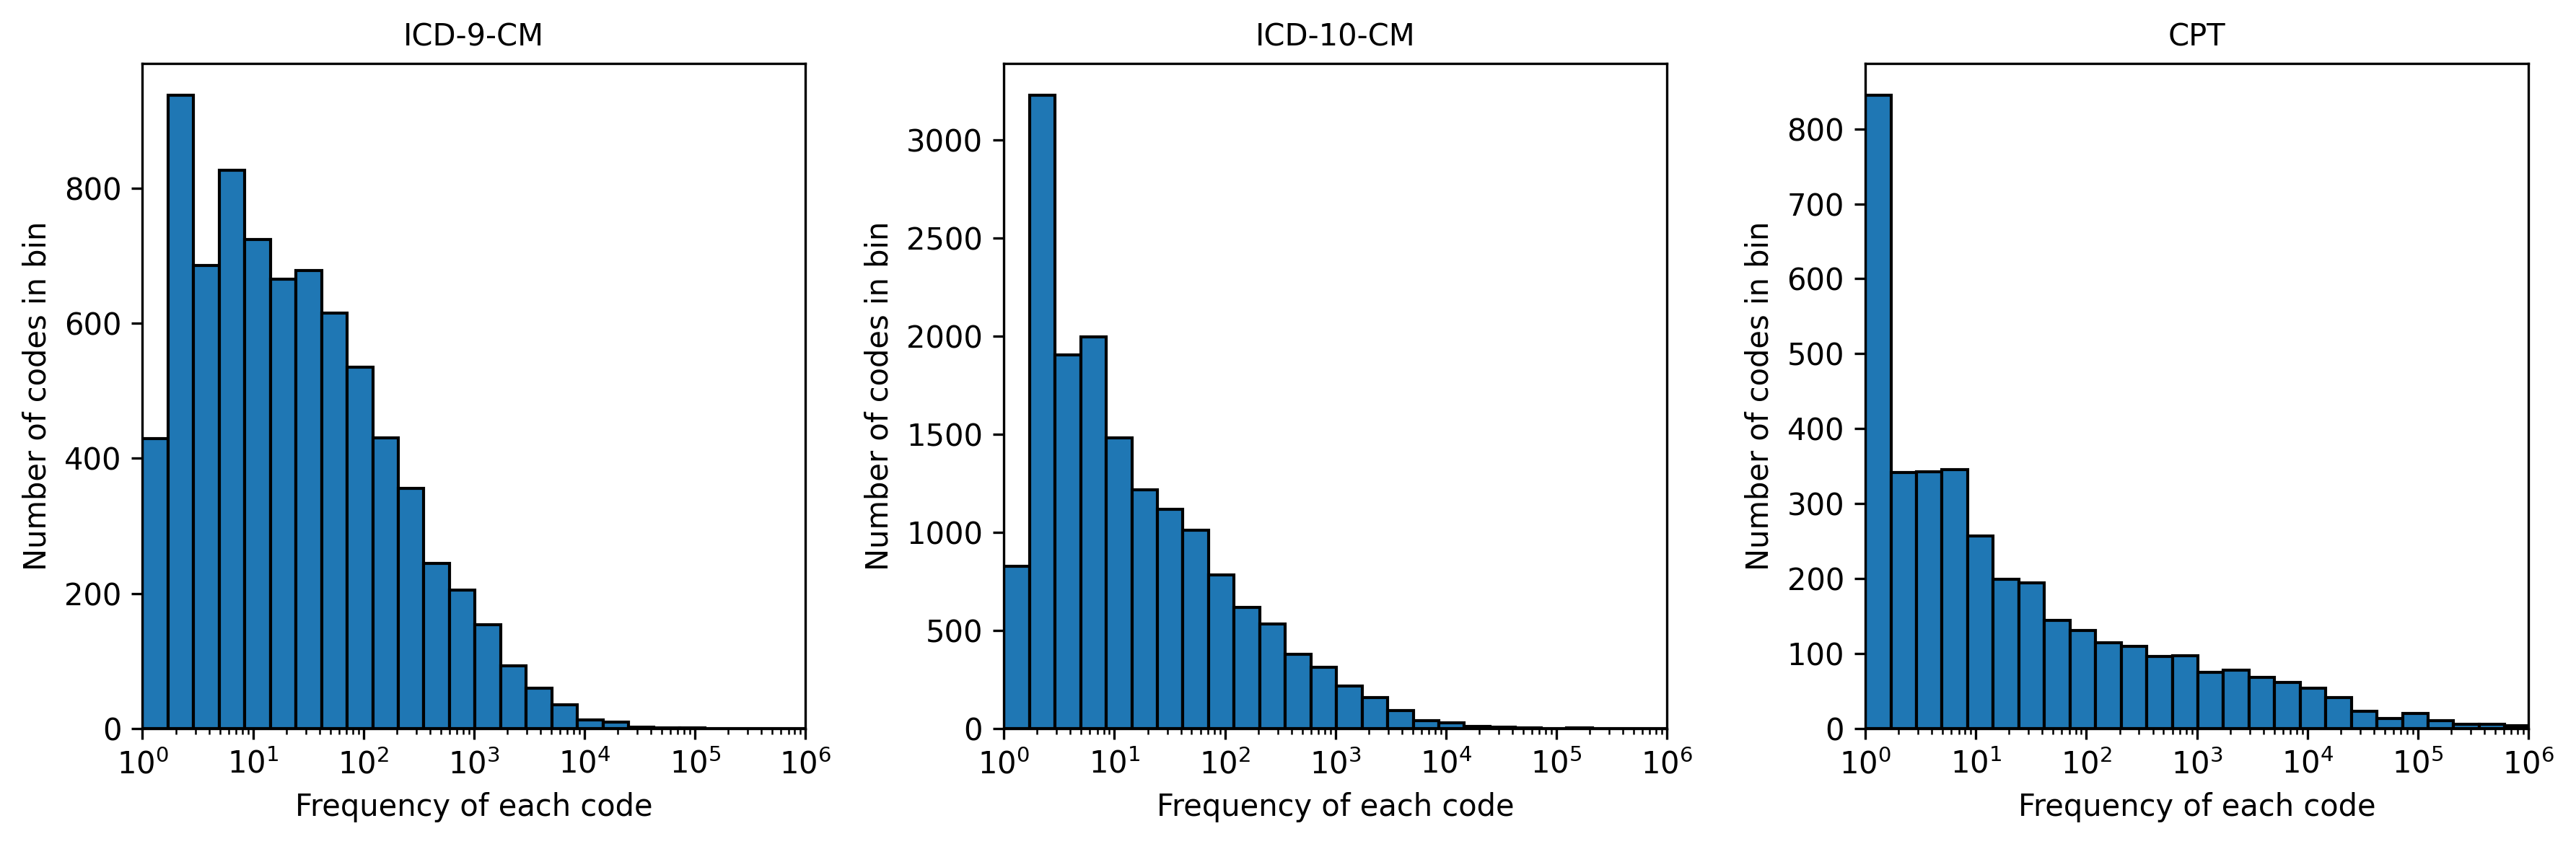

In [3]:
### CODE HISTOGRAM ### - Figure 1

code_histogram()

In [2]:
## Metric Table ## - Table 1,2,3,4 
df_metrictable_full = create_metric_table(suffix=base_suffix)
df_metrictable_man = create_metric_table(suffix=suffix_man)
df_metrictable_full_error = create_metric_table(suffix=base_suffix, error_analysis=True)
df_metrictable_man_error = create_metric_table(suffix=suffix_man, error_analysis=True)

print("Full analysis")
display(df_metrictable_full_error)
print('Manual subsample analysis')
display(df_metrictable_man_error)

Full analysis


gemini-pro  \
Code System Metric                                                              
ICD9CM      BillableCode                                                69.8%   
            LengthMatch                                                 62.7%   
            DigitMatch_Ovr                                              53.2%   
            DigitMatch_Ind   1: 82.9%\n2: 75.4%\n3: 55.2%\n4: 24.5%\n5: 11.4%   
            cui2vec                                                      0.59   
            icdcodex                                                      0.5   
            meteor15                                                    0.153   
            bertscore                                                   0.724   
ICD10CM     BillableCode                                                50.0%   
            LengthMatch                                                 58.9%   
            DigitMatch_Ovr                                              51.6%   
            DigitMatch_Ind  1: 88.0%\n2: 75.3%\n3: 59.7%\n4: 22.7%\n5: 18....   
            cui2vec                                                     0.349   
            icdcodex                                                      0.5   
            meteor15                                                    0.188   
            bertscore                                                   0.752   
CPT         LengthMatch                                                 98.7%   
            DigitMatch_Ovr                                              53.7%   
            DigitMatch_Ind   1: 92.5%\n2: 78.2%\n3: 52.5%\n4: 25.5%\n5: 19.9%   
            meteor15                                                    0.187   
            bertscore                                                   0.689   

                                                            gpt-35-turbo-0301  \
Code System Metric                                                              
ICD9CM      BillableCode                                                86.5%   
            LengthMatch                                                 69.3%   
            DigitMatch_Ovr                                              55.9%   
            DigitMatch_Ind   1: 81.3%\n2: 78.1%\n3: 64.3%\n4: 26.0%\n5: 16.8%   
            cui2vec                                                     0.644   
            icdcodex                                                      0.5   
            meteor15                                                     0.19   
            bertscore                                                   0.749   
ICD10CM     BillableCode                                                67.3%   
            LengthMatch                                                 54.4%   
            DigitMatch_Ovr                                              57.0%   
            DigitMatch_Ind  1: 86.4%\n2: 81.7%\n3: 73.3%\n4: 31.1%\n5: 26....   
            cui2vec                                                     0.423   
            icdcodex                                                    0.501   
            meteor15                                                    0.239   
            bertscore                                                   0.786   
CPT         LengthMatch                                                 99.4%   
            DigitMatch_Ovr                                              58.2%   
            DigitMatch_Ind   1: 95.8%\n2: 80.5%\n3: 64.2%\n4: 34.2%\n5: 16.5%   
            meteor15                                                    0.235   
            bertscore                                                   0.728   

                                                            gpt-35-turbo-0613  \
Code System Metric                                                              
ICD9CM      BillableCode                                                91.0%   
            LengthMatch                                                 72.5%   
            Dig

Manual subsample analysis


gemini-pro  \
Code System Metric                                                              
ICD9CM      BillableCode                                                62.6%   
            LengthMatch                                                 51.9%   
            DigitMatch_Ovr                                              61.1%   
            DigitMatch_Ind   1: 84.0%\n2: 82.4%\n3: 67.2%\n4: 35.2%\n5: 13.5%   
            Avg_STS                                                       1.5   
            cui2vec                                                     0.635   
            icdcodex                                                    0.491   
            meteor15                                                    0.157   
            bertscore                                                   0.719   
ICD10CM     BillableCode                                                47.9%   
            LengthMatch                                                 55.6%   
            DigitMatch_Ovr                                              56.9%   
            DigitMatch_Ind  1: 88.9%\n2: 79.9%\n3: 59.0%\n4: 21.9%\n5: 22....   
            Avg_STS                                                       1.5   
            cui2vec                                                     0.455   
            icdcodex                                                    0.497   
            meteor15                                                    0.195   
            bertscore                                                   0.763   
CPT         LengthMatch                                                 97.2%   
            DigitMatch_Ovr                                              58.3%   
            DigitMatch_Ind   1: 97.2%\n2: 78.5%\n3: 60.4%\n4: 36.8%\n5: 18.8%   
            Avg_STS                                                       1.1   
            meteor15                                                    0.227   
            bertscore                                                   0.729   

                                                            gpt-35-turbo-0301  \
Code System Metric                                                              
ICD9CM      BillableCode                                                91.1%   
            LengthMatch                                                 64.6%   
            DigitMatch_Ovr                                              53.7%   
            DigitMatch_Ind   1: 77.2%\n2: 74.7%\n3: 62.0%\n4: 24.4%\n5: 16.3%   
            Avg_STS                                                       2.1   
            cui2vec                                                     0.629   
            icdcodex                                                    0.504   
            meteor15                                                    0.184   
            bertscore                                                   0.737   
ICD10CM     BillableCode                                                65.9%   
            LengthMatch                                                 58.5%   
            DigitMatch_Ovr                                              61.9%   
            DigitMatch_Ind  1: 87.8%\n2: 85.4%\n3: 68.3%\n4: 34.2%\n5: 40....   
            Avg_STS                                                       2.0   
            cui2vec                                                      0.57   
            icdcodex                                                    0.498   
            meteor15                                                    0.248   
            bertscore                                                   0.786   
CPT         LengthMatch                                                 97.1%   
            DigitMatch_Ovr                                              46.5%   
            DigitMatch_Ind   1: 98.1%\n2: 52.4%\n3: 42.9%\n4: 21.9%\n5: 17.1%   
            Avg_STS                                                       0.7   
            mete

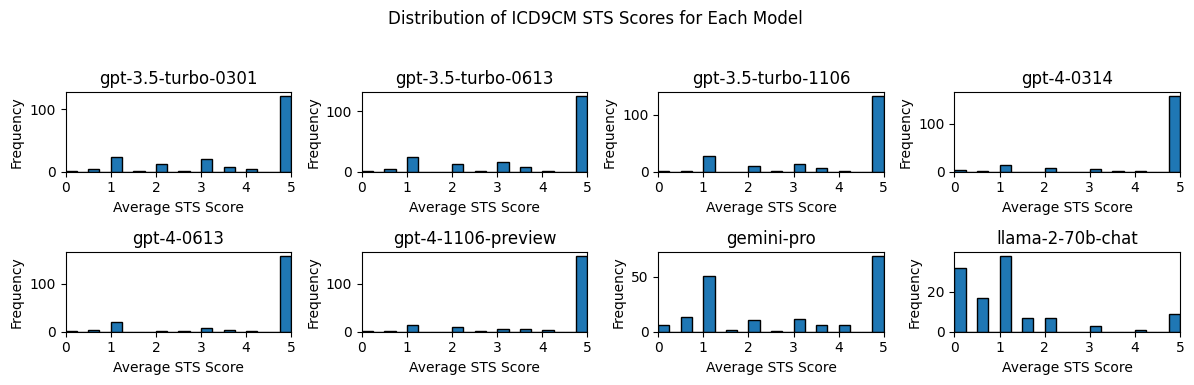

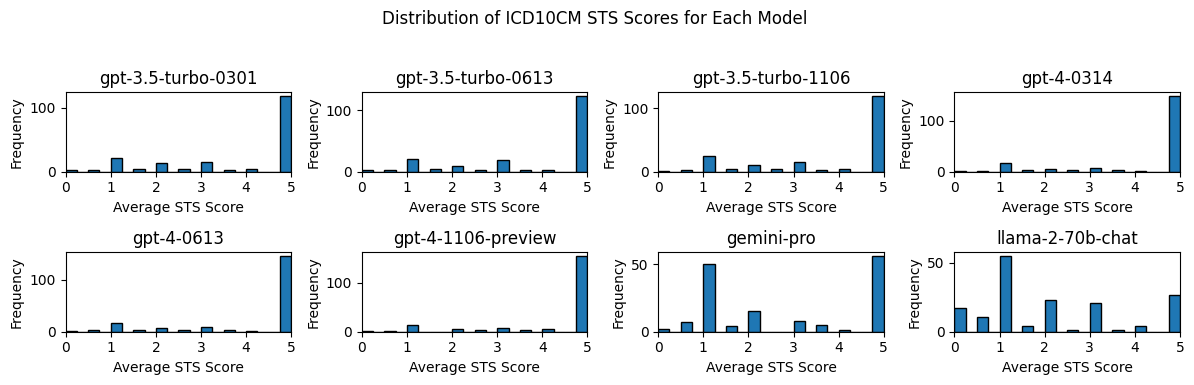

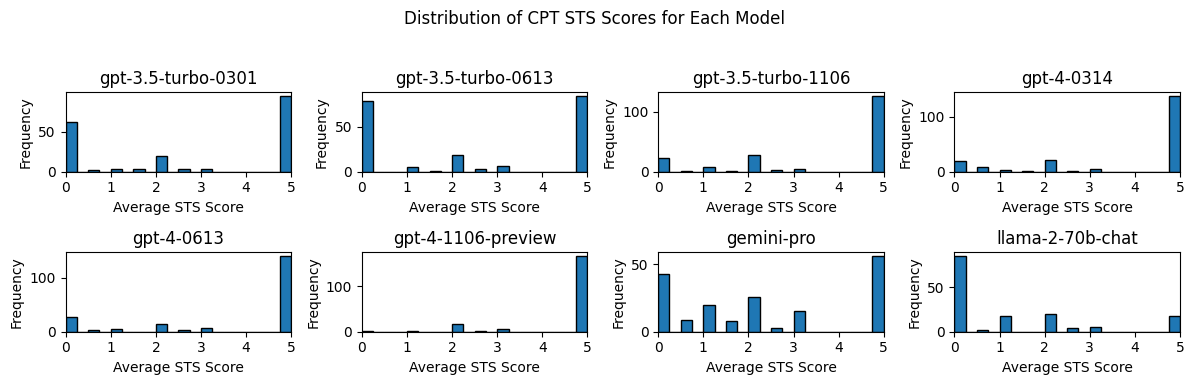

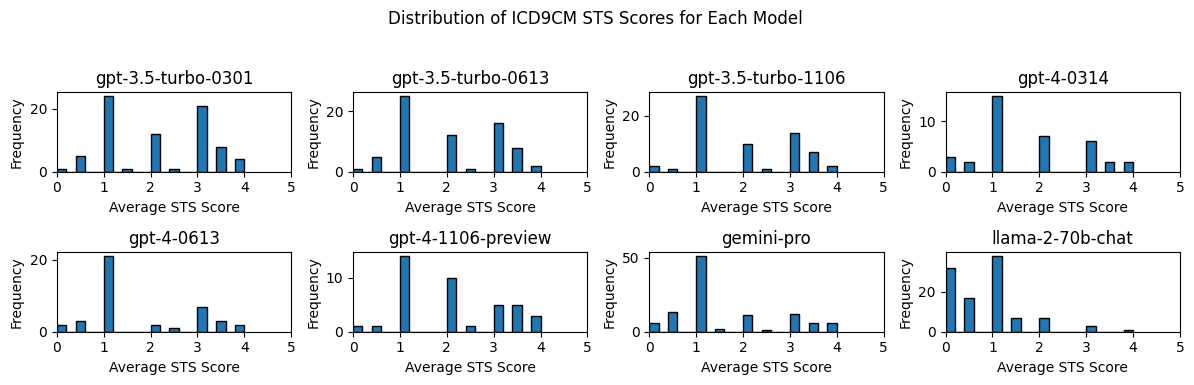

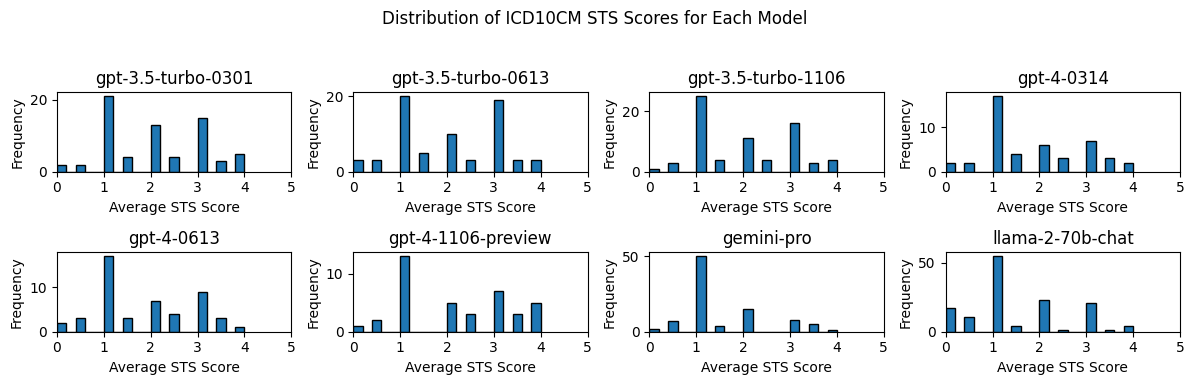

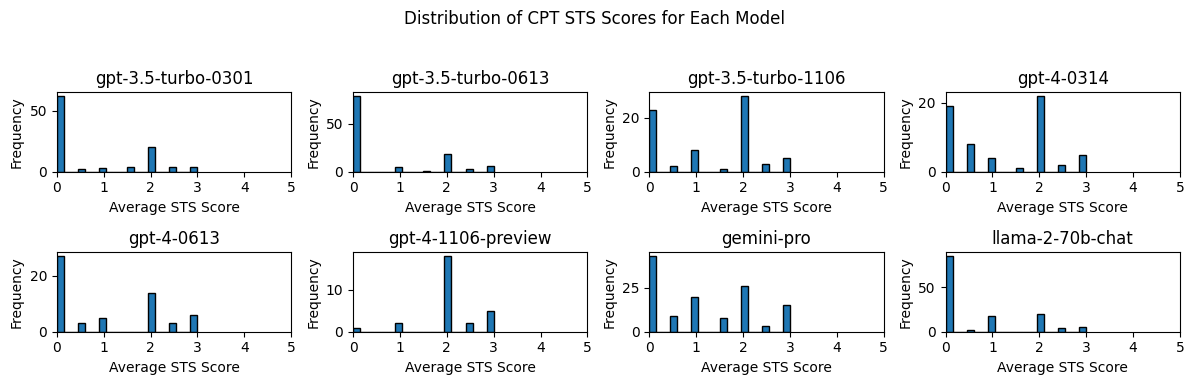

In [2]:
## Semantic Similary Figure ## - Figure 2
sts_score_dist_fig()
sts_score_dist_fig(error_analysis=True)

ICD9CM


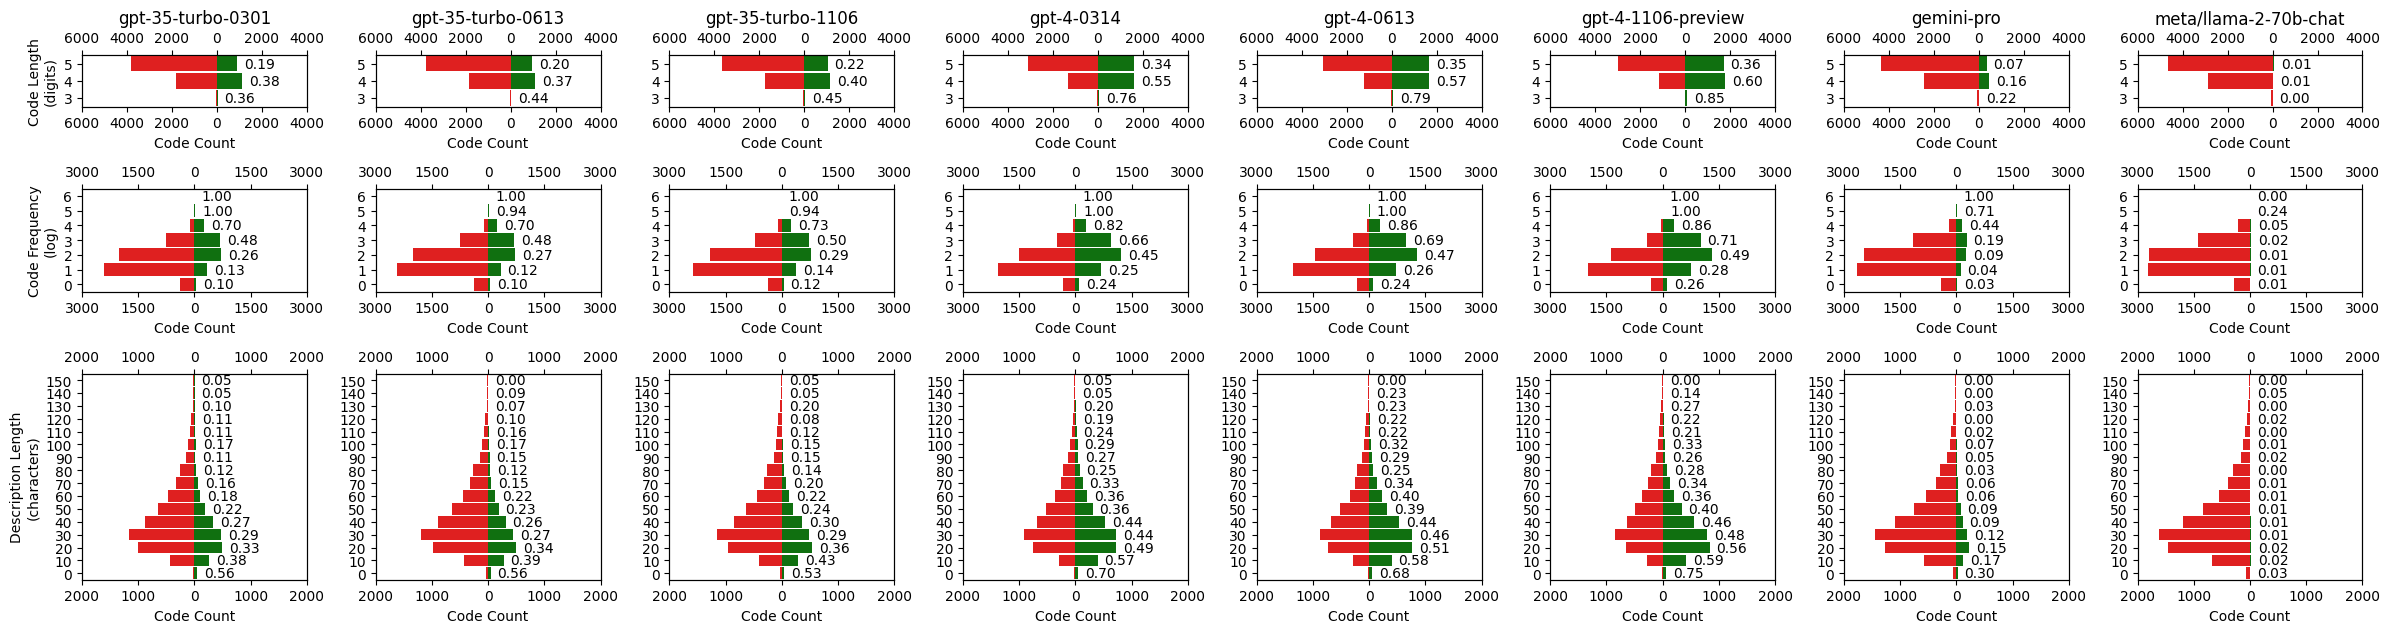

ICD10CM


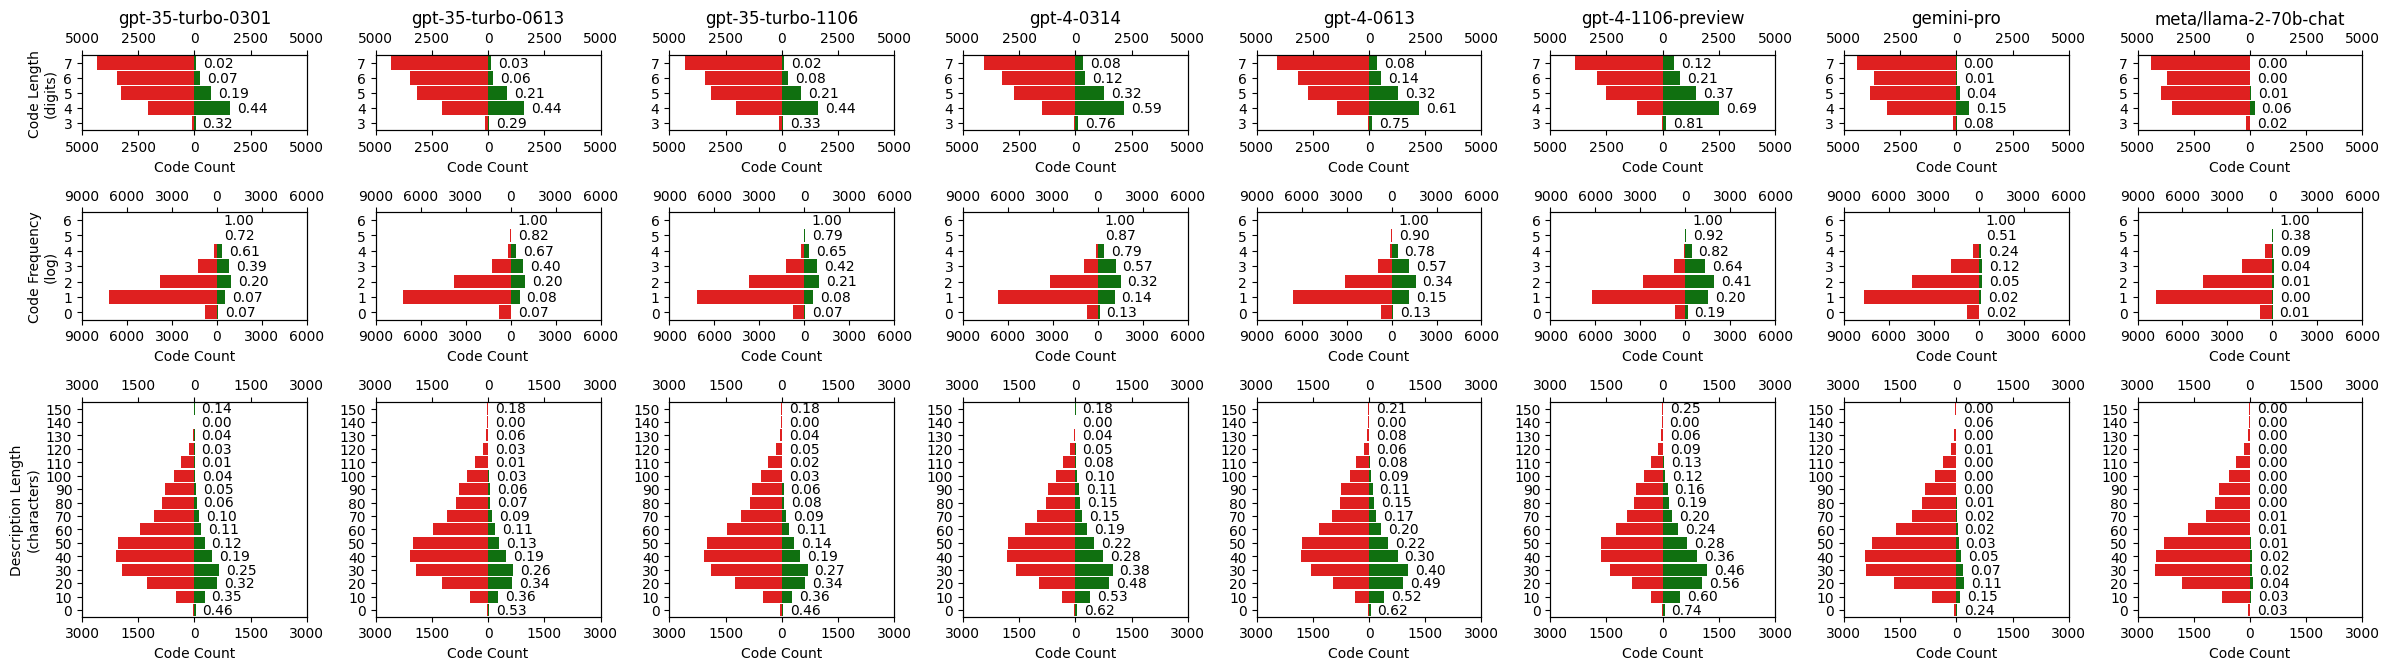

CPT


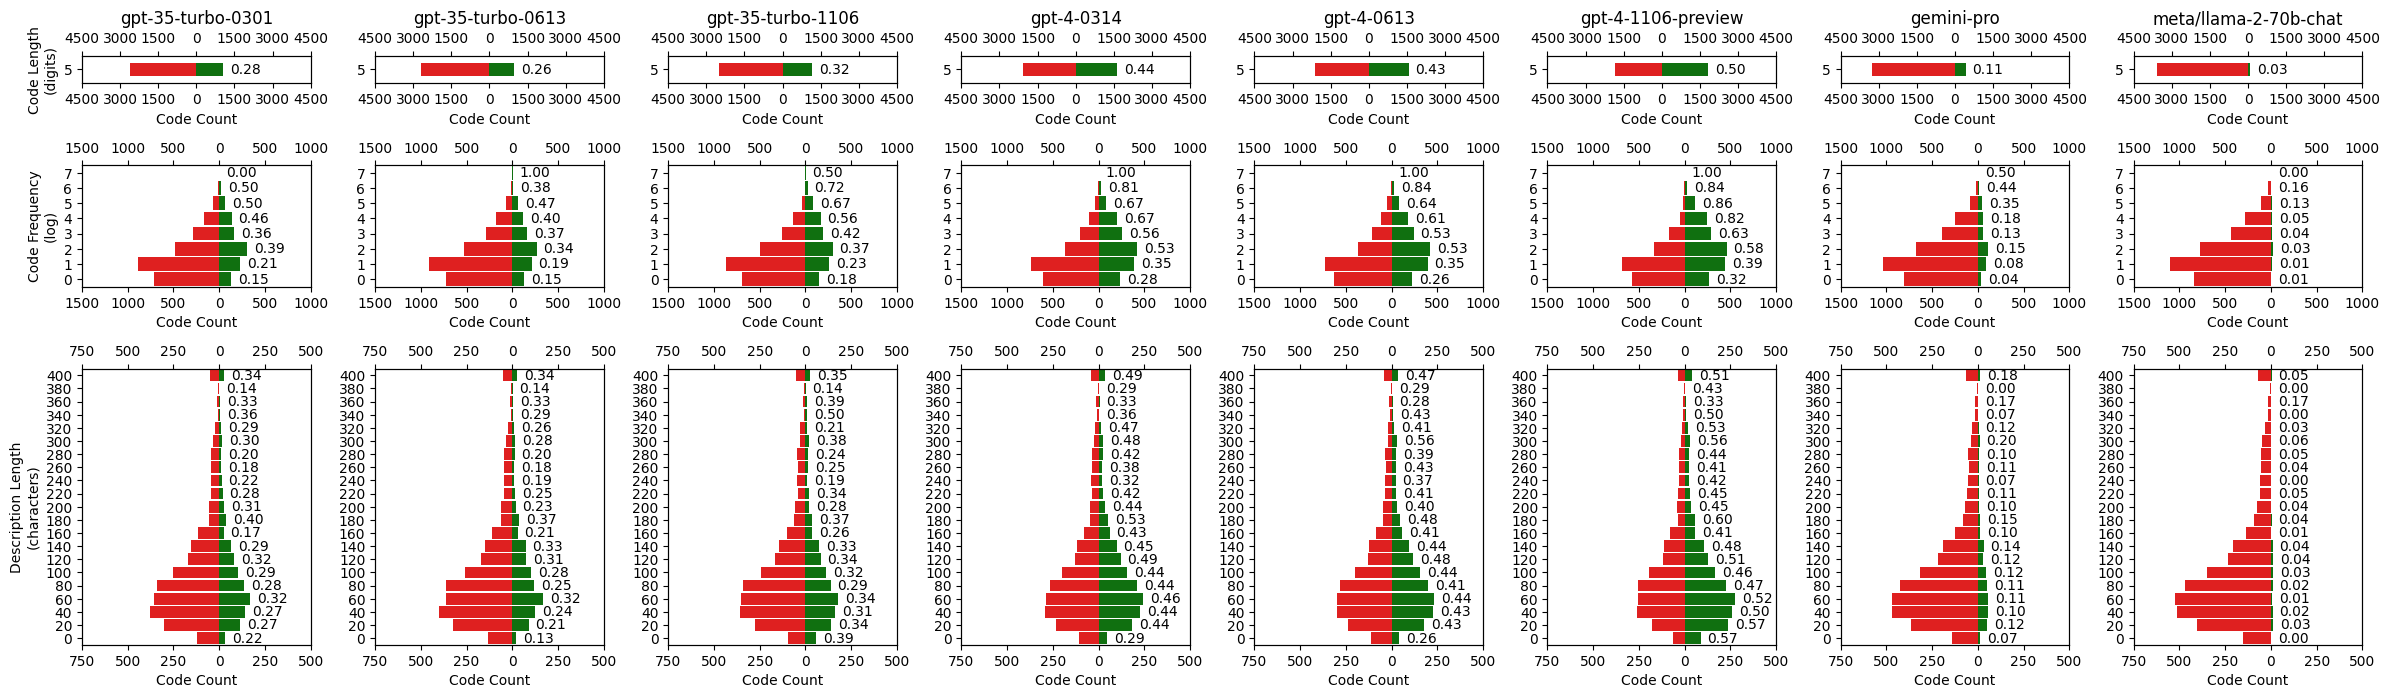

In [2]:
## Code Feature Distribution ## - Figure 3
code_features_dist(base_suffix)
#code_features_dist(suffix_man)

# need to fix y axis labels 

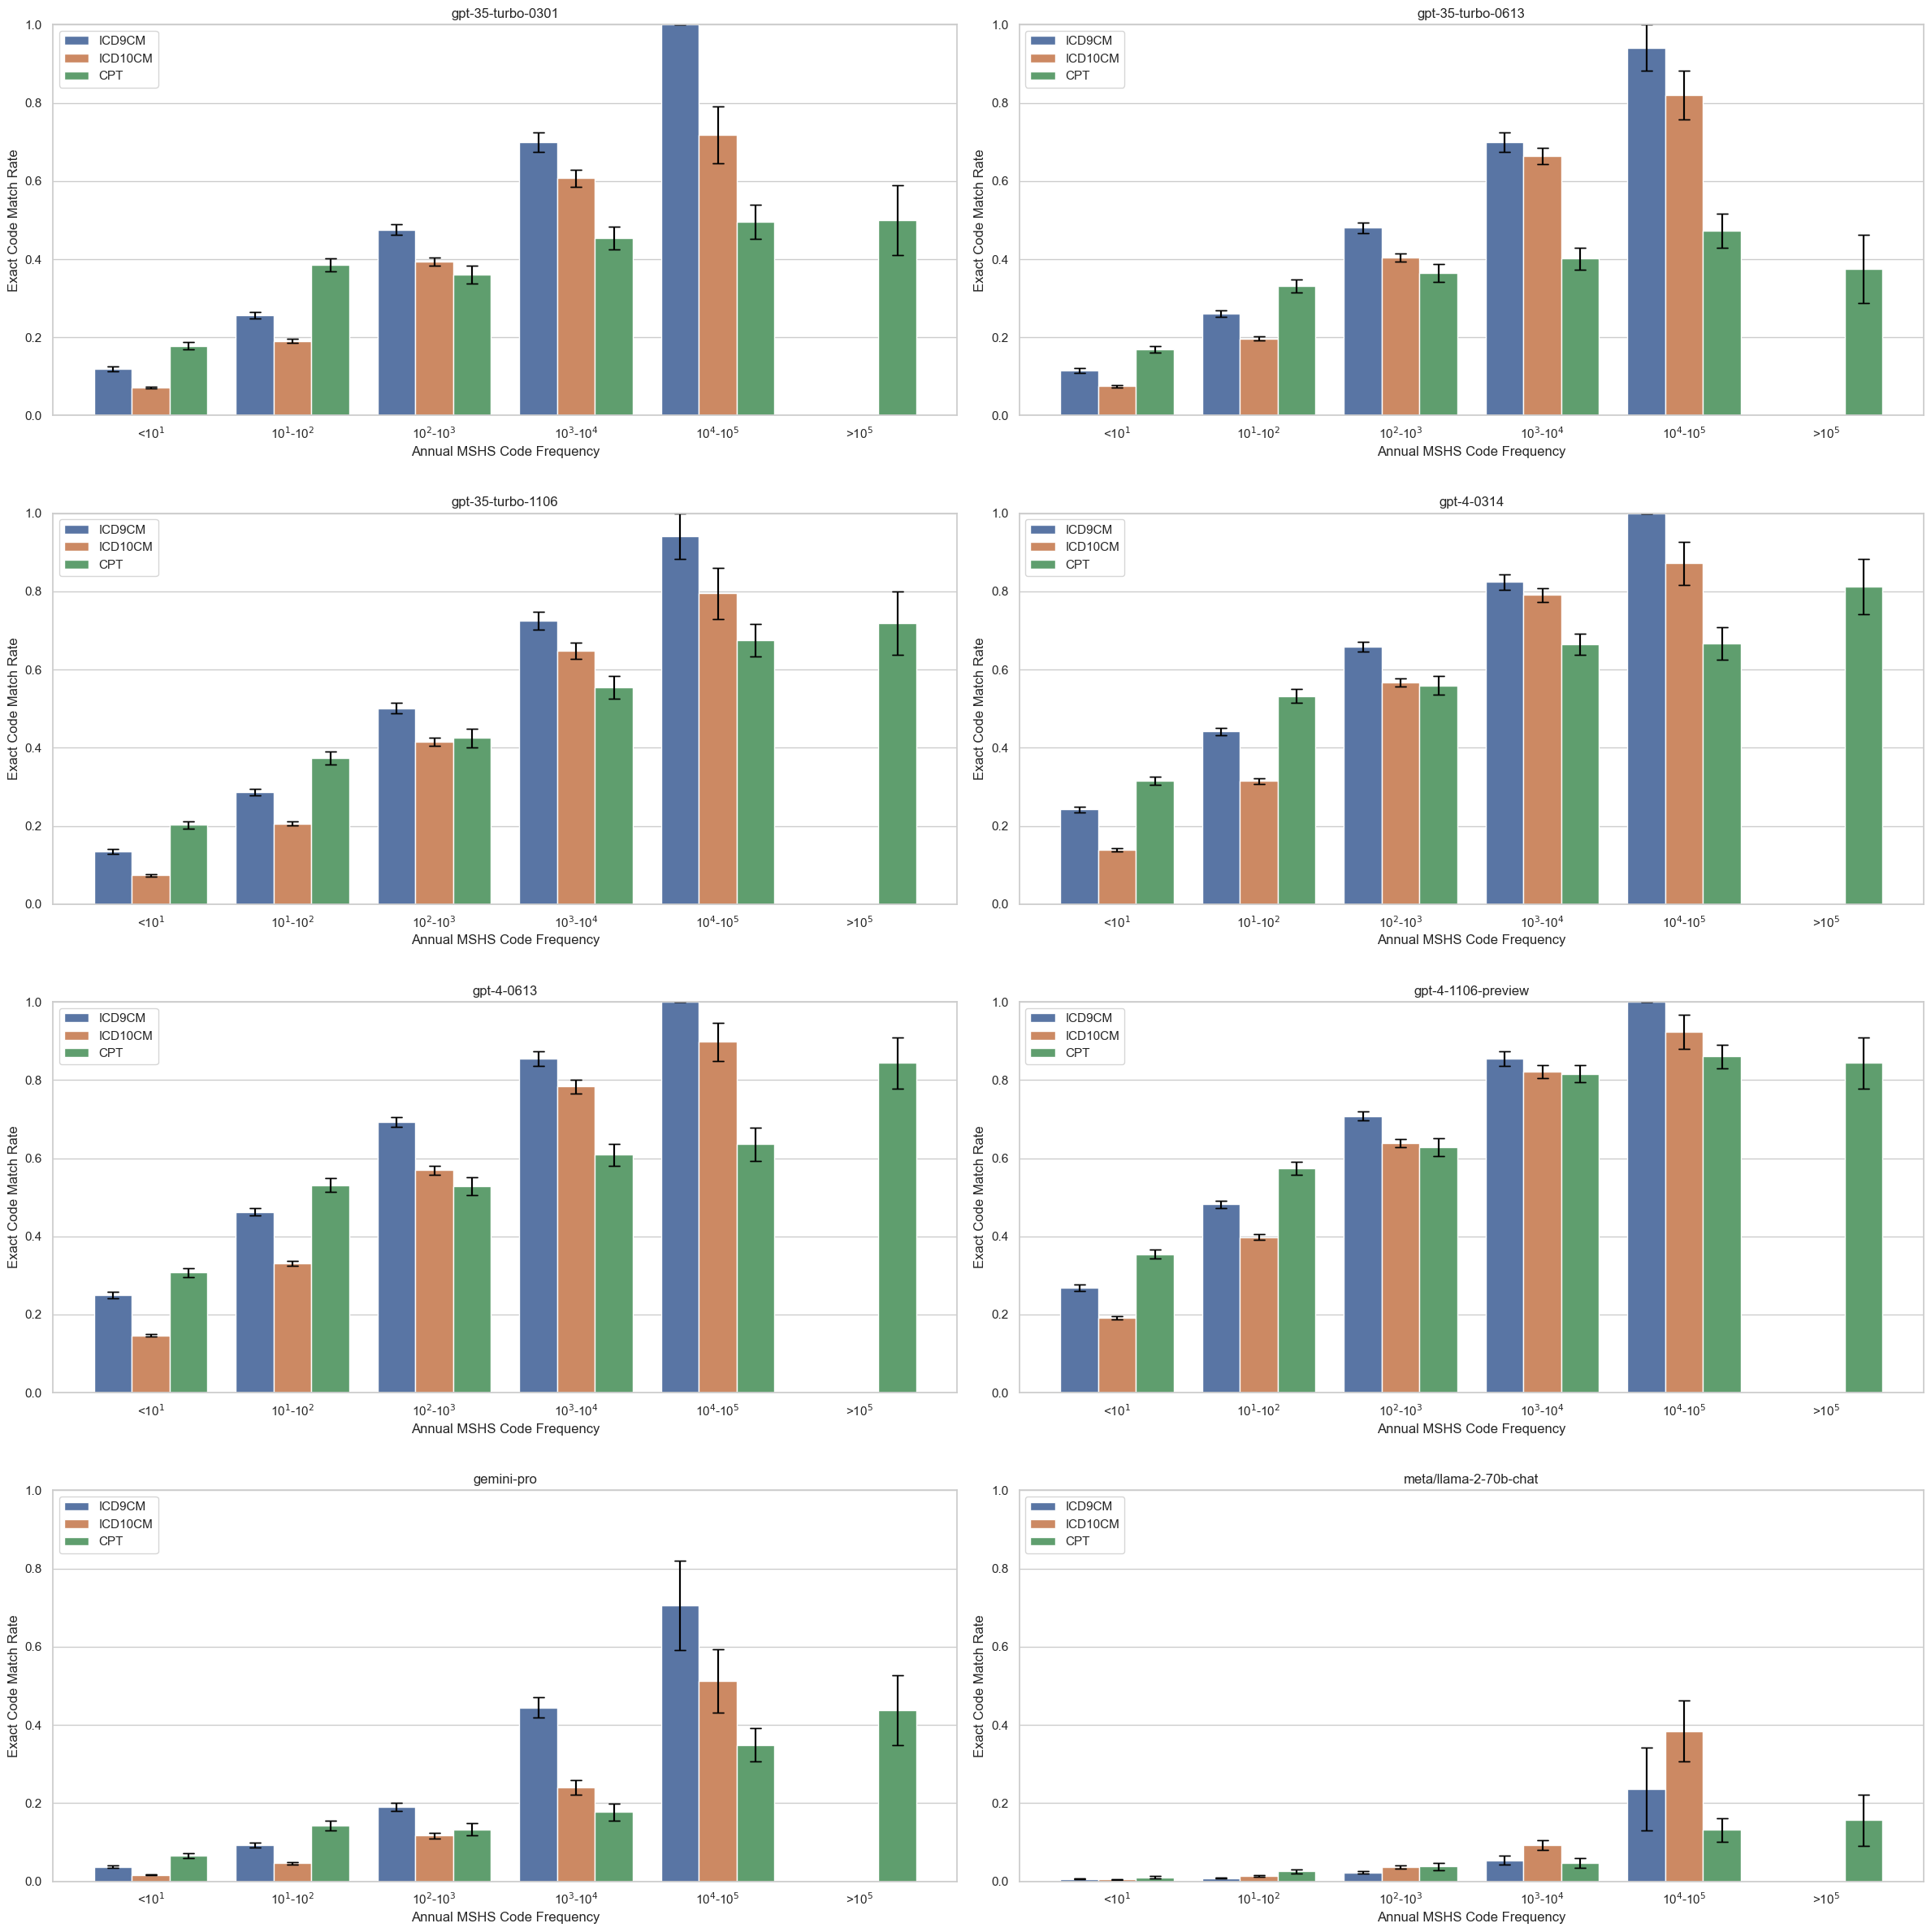

In [13]:
## Frequency chart ##
frequencychart(model_list, base_suffix)

In [ ]:
#test